# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [26]:
import numpy as np
import os
from scipy.misc import imread, imresize
import datetime
import os

In [27]:
import imageio
import skimage

We set the random seed so that the results don't vary drastically.

In [28]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.set_random_seed(30)

In [29]:
import abc
from sys import getsizeof

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [30]:
train_doc = np.random.permutation(open('./Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('./Project_data/val.csv').readlines())
batch_size = 10 #experiment with the batch size

In [31]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.layers.recurrent import LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.layers import Dropout

In [32]:
project_folder='Project_data'

In [33]:
sample_image = os.listdir('./Project_data/train'+'/'+ np.random.permutation(train_doc)[0 + (0)].split(';')[0])

In [34]:
sample_im_path = './Project_data/train'+'/'+ train_doc[0].split(';')[0]
sample = imageio.imread(sample_im_path+'/'+os.listdir(sample_im_path)[0])

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline

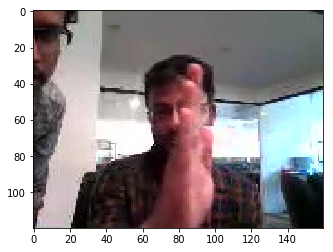

In [36]:
plt.imshow(sample)

In [37]:
sample.shape

(120, 160, 3)

In [38]:
sample = skimage.transform.resize(sample,(50,50))

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


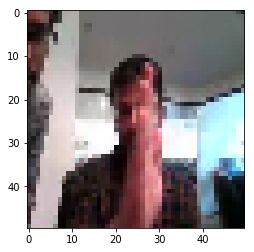

In [39]:
plt.imshow(sample)

In [40]:
sample.shape

(50, 50, 3)

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [41]:
class ModelBuilder(metaclass= abc.ABCMeta):
    
    def initialize_path(self,project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
        
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
          
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels     

In [42]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
#    img_idx = [x for x in range(0, nb_frames)]  #create a list of image numbers you want to use for a particular video
    img_idx = np.arange(0,30,3) #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size, len(img_idx), 50, 50, 3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image = skimage.transform.resize(image,(50,50))
                    image = image - np.percentile(image,5)/ np.percentile(image,95) - np.percentile(image,5)
                    batch_data[folder,idx,:,:,0] = image[:,:,0]
                    batch_data[folder,idx,:,:,1] = image[:,:,1]
                    batch_data[folder,idx,:,:,2] = image[:,:,2]
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        rem_image = len(folder_list)%batch_size
        batch += 1
        if(rem_image!=0):
            batch_data = np.zeros((rem_image,len(img_idx),50,50,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((rem_image,5)) # batch_labels is the one hot representation of the output
            for folder in range(rem_image): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                   
                    image = skimage.transform.resize(image,(50,50))
                    image = image - np.percentile(image,5)/ np.percentile(image,95) - np.percentile(image,5)
                    batch_data[folder,idx,:,:,0] = image[:,:,0]
                    batch_data[folder,idx,:,:,1] = image[:,:,1]
                    batch_data[folder,idx,:,:,2] = image[:,:,2]
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels
            

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [43]:
curr_dt_time = datetime.datetime.now()
train_path = './Project_data/train'
val_path = './Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 50 # choose the number of epochs
print ('# epochs =', num_epochs)
num_classes = 5

# training sequences = 663
# validation sequences = 100
# epochs = 50


In [44]:
# Parameters initialization
nb_rows = 120   # X dimension of the image
nb_cols = 120   # Y dimesnion of the image
#total_frames = 30
nb_frames = 30  # lenght of the video frames
nb_channel = 3 # numbe rof channels in images 3 for color(RGB) and 1 for Gray

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [45]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.regularizers import l2
from keras import optimizers

#write your model here
model = Sequential()

model.add(TimeDistributed(Conv2D(16, (2, 2), padding='same'),
                 input_shape=(10,50,50,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(TimeDistributed(Conv2D(16, (2, 2))))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
model.add(Dropout(0.2))

model.add(TimeDistributed(Conv2D(32, (2, 2), padding='same')))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(TimeDistributed(Conv2D(32, (2, 2), padding='same')))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
model.add(Dropout(0.2))

model.add(TimeDistributed(Flatten()))
model.add(LSTM(256, return_sequences=False, dropout=0.5))
model.add(Dense(64,kernel_regularizer=l2(0.01)))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
 

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [46]:
#optimiser =  #write your optimizer
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_8 (TimeDist (None, 10, 50, 50, 16)    208       
_________________________________________________________________
activation_7 (Activation)    (None, 10, 50, 50, 16)    0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 10, 50, 50, 16)    64        
_________________________________________________________________
time_distributed_9 (TimeDist (None, 10, 49, 49, 16)    1040      
_________________________________________________________________
activation_8 (Activation)    (None, 10, 49, 49, 16)    0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 10, 49, 49, 16)    64        
_________________________________________________________________
time_distributed_10 (TimeDis (None, 10, 24, 24, 16)    0         
__________

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [47]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [48]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.01)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [49]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [50]:
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  ./Project_data/val ; batch size = 10
Source path =  ./Project_data/train ; batch size = 10
Epoch 1/50


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


67/67 [==============================] - 40s 600ms/step - loss: 2.6463 - categorical_accuracy: 0.2542 - val_loss: 2.4362 - val_categorical_accuracy: 0.4200

Epoch 00001: saving model to model_init_2020-09-0520_40_53.576896/model-00001-2.64660-0.25339-2.43622-0.42000.h5
Epoch 2/50
67/67 [==============================] - 33s 499ms/step - loss: 2.4477 - categorical_accuracy: 0.3527 - val_loss: 2.2908 - val_categorical_accuracy: 0.4000

Epoch 00002: saving model to model_init_2020-09-0520_40_53.576896/model-00002-2.44580-0.35294-2.29078-0.40000.h5
Epoch 3/50
67/67 [==============================] - 36s 545ms/step - loss: 2.2479 - categorical_accuracy: 0.4502 - val_loss: 2.0818 - val_categorical_accuracy: 0.5300

Epoch 00003: saving model to model_init_2020-09-0520_40_53.576896/model-00003-2.24961-0.44796-2.08184-0.53000.h5
Epoch 4/50
67/67 [==============================] - 37s 559ms/step - loss: 2.0958 - categorical_accuracy: 0.5552 - val_loss: 2.0839 - val_categorical_accuracy: 0.5300



In [51]:
## 2. Convolution 3D Model

In [59]:
from keras.optimizers import Adam
# Parameters initialization
rows = 50   # X dimension of the image
cols = 50  # Y dimesnion of the image
#total_frames = 30
frames = 10  # lenght of the video frames
channel = 3 # numbe rof channels in images 3 for color(RGB) and 1 for Gray
nb_featuremap = [8,16,32,64]
nb_dense = [128,64,5]
nb_classes = 5
# Input
input_shape=(frames,rows,cols,channel)

model3d = Sequential()
model3d.add(Conv3D(nb_featuremap[0], 
                 kernel_size=(5,5,5),
                 input_shape=input_shape,
                 padding='same', name="conv1"))
model3d.add(Activation('relu'))
model3d.add(Conv3D(nb_featuremap[1], 
                 kernel_size=(3,3,3),
                 padding='same',name="conv2"))
model3d.add(Activation('relu'))
model3d.add(MaxPooling3D(pool_size=(2,2,2)))
model3d.add(Conv3D(nb_featuremap[2], 
                 kernel_size=(1,3,3), 
                 padding='same',name="conv3"))
model3d.add(Activation('relu'))
model3d.add(MaxPooling3D(pool_size=(2,2,2)))
model3d.add(BatchNormalization())
model3d.add(Dropout(0.25))
model3d.add(MaxPooling3D(pool_size=(2,2,2)))
model3d.add(Flatten())
model3d.add(Dense(nb_dense[0], activation='relu'))
model3d.add(Dropout(0.25))
model3d.add(Dense(nb_dense[1], activation='relu'))
#softmax layer
model3d.add(Dense(nb_dense[2], activation='softmax'))
optimiser = Adam(0.001)
#model3d.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model3d.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

print (model3d.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv3D)               (None, 10, 50, 50, 8)     3008      
_________________________________________________________________
activation_25 (Activation)   (None, 10, 50, 50, 8)     0         
_________________________________________________________________
conv2 (Conv3D)               (None, 10, 50, 50, 16)    3472      
_________________________________________________________________
activation_26 (Activation)   (None, 10, 50, 50, 16)    0         
_________________________________________________________________
max_pooling3d_13 (MaxPooling (None, 5, 25, 25, 16)     0         
_________________________________________________________________
conv3 (Conv3D)               (None, 5, 25, 25, 32)     4640      
_________________________________________________________________
activation_27 (Activation)   (None, 5, 25, 25, 32)     0         
__________

In [60]:
model3d.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,callbacks=callbacks_list, validation_data=val_generator,validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0,use_multiprocessing=True)

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("An

Epoch 1/50
67/67 [==============================] - 41s 612ms/step - loss: 1.7337 - categorical_accuracy: 0.2766 - val_loss: 1.4168 - val_categorical_accuracy: 0.3800

Epoch 00001: saving model to model_init_2020-09-0520_40_53.576896/model-00001-1.73429-0.27602-1.41683-0.38000.h5
Epoch 2/50
67/67 [==============================] - 34s 505ms/step - loss: 1.4312 - categorical_accuracy: 0.3732 - val_loss: 1.4560 - val_categorical_accuracy: 0.4200

Epoch 00002: saving model to model_init_2020-09-0520_40_53.576896/model-00002-1.43026-0.37707-1.45596-0.42000.h5
Epoch 3/50
67/67 [==============================] - 39s 589ms/step - loss: 1.3445 - categorical_accuracy: 0.4189 - val_loss: 1.2999 - val_categorical_accuracy: 0.4200

Epoch 00003: saving model to model_init_2020-09-0520_40_53.576896/model-00003-1.34714-0.41629-1.29989-0.42000.h5
Epoch 4/50
67/67 [==============================] - 34s 514ms/step - loss: 1.2469 - categorical_accuracy: 0.4771 - val_loss: 1.2845 - val_categorical_accurac